In [ ]:
import numpy as np
import pandas as pd
import re

df=pd.read_csv('Twitter Sentiments.csv')
df.head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
def remove_pattern(input_text,pattern):
  r=re.findall(pattern,input_text)
  for word in r:
    input_text=re.sub(word,"",input_text)
  return input_text


In [ ]:
df['clean_tweet']=np.vectorize(remove_pattern)(df['tweet'],"@[\w]*")
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [ ]:
df['clean_tweet']=df['clean_tweet'].str.replace("[^a-zA-Z#]"," ")
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [ ]:
df['clean_tweet']=df['clean_tweet'].apply(lambda x:" ".join([w for w in x.split() if len(w)>3]))
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguide society #motivation


In [ ]:
tokenized_tweet=df['clean_tweet'].apply(lambda x:x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer=PorterStemmer()
tokenized_tweet=tokenized_tweet.apply(lambda sentence:[stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: clean_tweet, dtype: object

In [ ]:
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i]=" ".join(tokenized_tweet[i])


In [ ]:
df['clean_tweet']=tokenized_tweet
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguid societi #motiv


In [ ]:
!pip install wordcloud

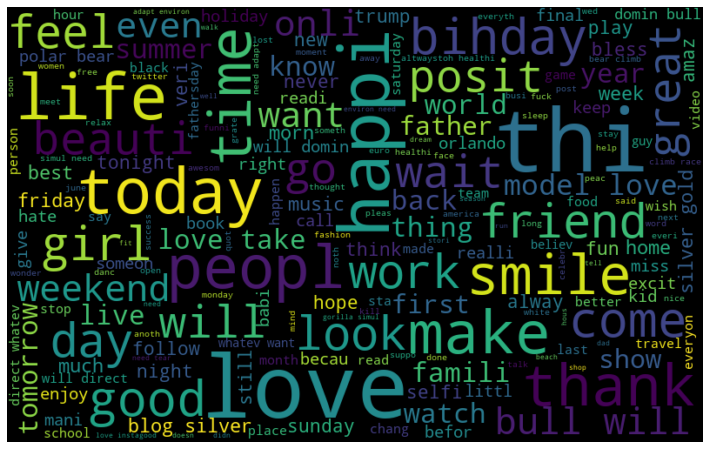

In [ ]:
all_words="".join([sentence for sentence in df['clean_tweet']])
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud=WordCloud(width=800,height=500,random_state=50,max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

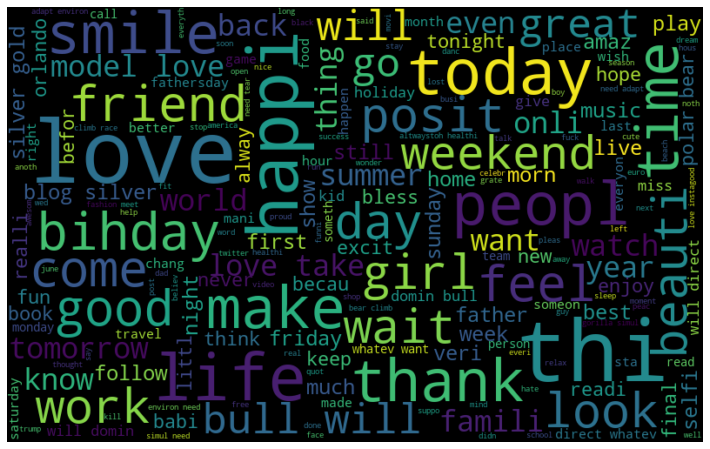

In [ ]:
all_words="".join([sentence for sentence in df['clean_tweet'][df['label']==0]])
wordcloud=WordCloud(width=800,height=500,random_state=50,max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

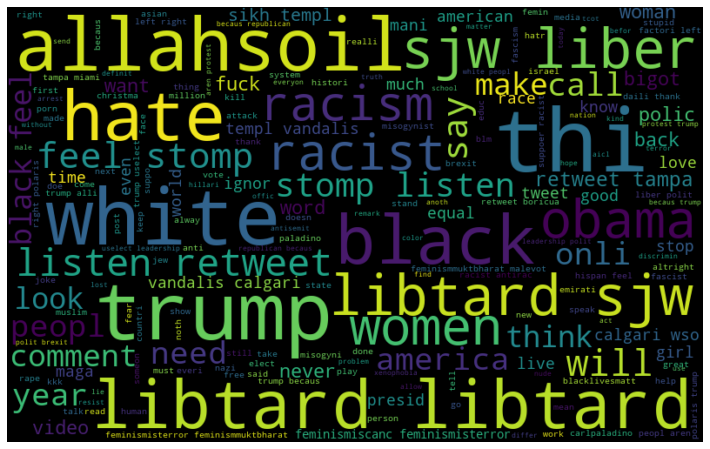

In [ ]:
all_words="".join([sentence for sentence in df['clean_tweet'][df['label']==1]])
wordcloud=WordCloud(width=800,height=500,random_state=50,max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
def hashtag_extract(tweets):
  hashtags=[]
  for tweet in tweets:
    ht=re.findall(r"#(\w+)",tweet)
    hashtags.append(ht)
  return hashtags  

In [ ]:
ht_positive=hashtag_extract(df['clean_tweet'][df['label']==0])

ht_negative=hashtag_extract(df['clean_tweet'][df['label']==1])

ht_positive[:5]

ht_negative[:5]
ht_positive=sum(ht_positive,[])
ht_negative=sum(ht_negative,[])

In [ ]:
import nltk
freq=nltk.FreqDist(ht_positive)
d=pd.DataFrame({'Hashtags':list(freq.keys()),
                'Count':list(freq.values())})
d.head()

,Hashtags,Count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


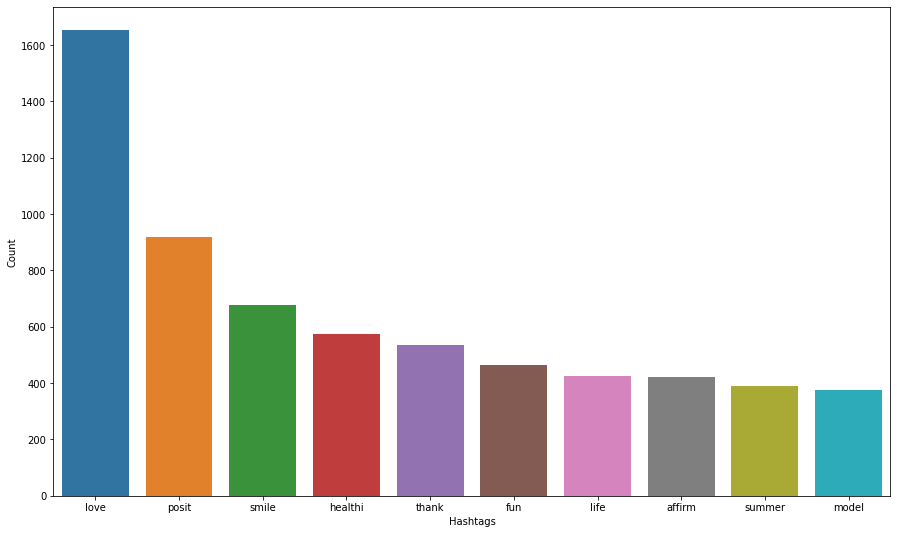

In [ ]:
import seaborn as sns
d=d.nlargest(columns='Count',n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d,x='Hashtags',y='Count')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer=CountVectorizer(max_df=0.9,min_df=2,max_features=1000,stop_words='english')
bow=bow_vectorizer.fit_transform(df['clean_tweet'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
x_train,x_test,y_train,y_test=train_test_split(bow,df['label'],random_state=50,test_size=0.3)

model=LogisticRegression();
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(f1_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
pred_prob=model.predict_proba(x_test)
y_pred=pred_prob[:1]>=0.3
y_pred=y_pred.astype(np.int)
print(f1_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

0.48063555114200596
0.94545833767859


ValueError: ignored